In [8]:
library(monocle3)
library(Seurat)
library(dplyr)
library(biomaRt)
library(stringr)
library(SCORPIUS)
library(ggplot2)
library(cowplot)
library(RColorBrewer)
library(scales)

In [3]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

In [12]:
integrated_meta = read.table(paste(out, "integrated_annotations.txt", sep = ""))

In [270]:
f = paste(out, "obj.integrated.frazer.melton", sep = "")
load(f, verbose = T)

Loading objects:
  integrated


In [271]:
integrated = integrated

In [272]:
Idents(integrated) <- "integrated_snn_res.0.05"

In [273]:
integrated@meta.data$major_cell_population = integrated_meta[match(rownames(integrated@meta.data), rownames(integrated_meta)), "major_cell_population"] 
integrated@meta.data$minor_cell_population = integrated_meta[match(rownames(integrated@meta.data), rownames(integrated_meta)), "minor_cell_population"] 

In [274]:
integrated@meta.data$study = "Frazer"
integrated@meta.data[integrated@meta.data$orig.ident == "x1", ]$study = "Melton"

# Figure 2A

In [117]:
PlotUMAP <- function(obj, annotate, lX, lY, text_width, n.col, plot_leg = FALSE, cols2use = NULL){

    options(repr.plot.width = 3, repr.plot.height = 3)
    par(mar = c(4, 4, 1, 1), xpd=FALSE)
    umap = as.data.frame(Embeddings(obj[["umap"]]))
    umap$clusters = obj@meta.data[match(rownames(umap), rownames(obj@meta.data)), annotate]
    
    qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
    col_vector    = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
    my_color_palette <- hue_pal()(length(unique(umap$clusters)))
    
    if(length(cols2use) > 0){colrs = data.frame(clusters = unique(umap$clusters), color = cols2use)}
    else{colrs = data.frame(clusters = sort(unique(umap$clusters)), color = my_color_palette)}
    umap$color = colrs[match(umap$clusters, colrs$clusters), "color"]
    

    
    plot(umap[, 1], umap[, 2],
         pch = 19, 
         xlab = "UMAP1",
         ylab = "UMAP2",
         col = umap$color,
         cex = .1,
         las = 1)

    if( plot_leg == TRUE){
        legend(lX, lY,
               legend = colrs$clusters,
               col    = colrs$color,
               pch    = rep(16, nrow(colrs)),
               cex=.9,
               bg="transparent",
               box.lty = 0,
               y.intersp = 1.75,
               ncol = n.col,
               x.intersp = 1.15,
               text.width = text_width)
    }
    
    return(colrs)
    
}

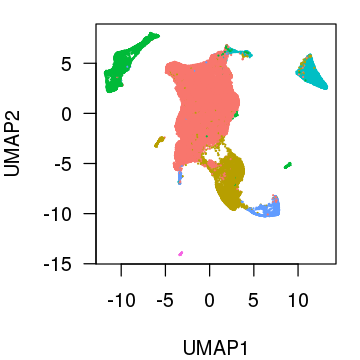

In [74]:
x = PlotUMAP(integrated, "integrated_snn_res.0.05", 3, 13, text_width = 2, n.col = 2, plot_leg = F)

In [237]:
integrated
x = as.data.frame(table(integrated@meta.data$integrated_snn_res.0.05))
x$frac = (x$Freq / sum(x$Freq)) *100
x

An object of class Seurat 
60358 features across 112509 samples within 2 assays 
Active assay: RNA (58358 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

Var1,Freq,frac
<fct>,<int>,<dbl>
0,74303,66.041828
1,15457,13.738456
2,9664,8.589535
3,9135,8.119350
4,3599,3.198855
5,351,0.311975


# Figure 2B

In [276]:
cols = data.frame(celltype = sort(unique(integrated@meta.data$major_cell_population)), col = c("#56ccd8", "#9c0031", "#4bb047", "#c3826c", "#a6cee3", "#5ebd53", "#d984c6", "#ff7f00", "#67c2a5", "#b2e18c",
                                                                                               "#ede99a", "#d49100", "#c9c230", "#a39000", "#827f80", "#e5191b", "#984ea4", "#387cb7", "#f69c9c"))
# colsrowadd = data.frame(celltype = NA, col =)
# cols = rbind(cols, colsrowadd)

In [424]:
write.csv(cols, file = "../Table/celltype_colors.csv")

In [275]:
unique(integrated@meta.data$Assigned_cluster)

[1] NA                 "repl"             "pdx1"             "nkx61"           
 [5] "sc_alpha"         "fev_high_isl_neg" "neurog3"          "sst_hhex"        
 [9] "exo"              "sc_beta"          "sc_ec"            "foxj1"

In [277]:
colsUSE = cols[cols$celltype %in% (unique(integrated@meta.data$Assigned_cluster)), "col" ][c(7, 6, 5, 8, 2, 4, 11, 1, 9, 10, 3)]
colsUSE = c( "#c7c7c7", colsUSE)

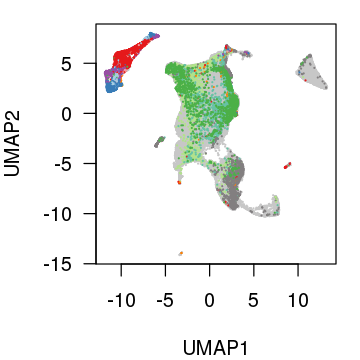

In [175]:
x = PlotUMAP(integrated, "Assigned_cluster", 2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Figure 2C

In [285]:
PlotFractionCellsStudy <- function(){

    options(repr.plot.width = 8, repr.plot.height = 6)
    
    par(mfrow = c(2, 1), mar = c(4, 5, 1, 1))
    data = t(table(integrated@meta.data$integrated_snn_res.0.05, integrated@meta.data$study))
    data = data[c(2, 1), ]
    barplot(data, col = c("#2c6954", "#84d9be"), las = 1, ylab = "N cells", xlab = "Cluster", , ylim = c(0, 80000))

    data = t(table(integrated@meta.data$integrated_snn_res.0.05, integrated@meta.data$Assigned_cluster))
    barplot(data, col = cols[cols$celltype %in% sort(unique(integrated@meta.data$Assigned_cluster)), "col"], las = 1, ylab = "N cells", xlab = "Cluster", ylim = c(0, 12000))
}

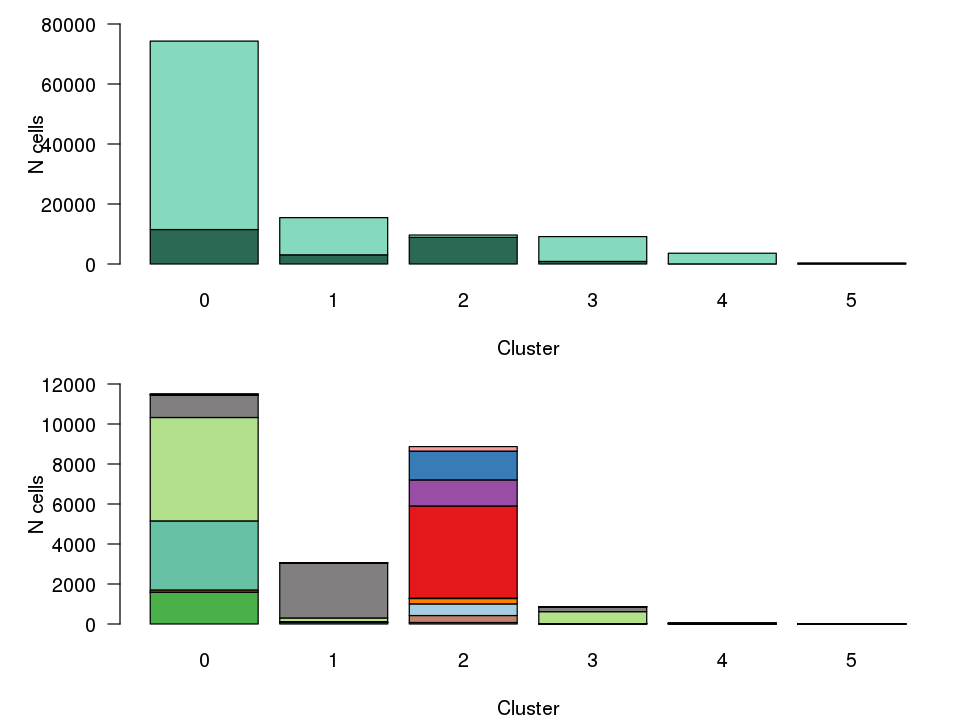

In [286]:
PlotFractionCellsStudy()

# Figure 2D

In [417]:
PlotGeneExpression <- function(obj){
    options(repr.plot.width = 3, repr.plot.height = 3)
    p <- FeaturePlot(obj, features = c("POU5F1", "PDX1", "NKX6-1", "CHGA", "INS", "PLVAP", "TOP2A", "COL3A1"),
                pt.size = .0001, min.cutoff = c(0, 0, 0, 1, 1, 1, 0, 0), max.cutoff = c(1.5, 1.5, 1.5, 50, 50, 2, 3, 1),
                combine = FALSE, cols = c("#c2c2c210","#910000"))

    for(i in 1:length(p)) {

        p[[i]] <- p[[i]] + NoLegend() + FontSize(main = 6) + NoAxes()

    }

    cowplot::plot_grid(plotlist = p, ncol = 3)
}


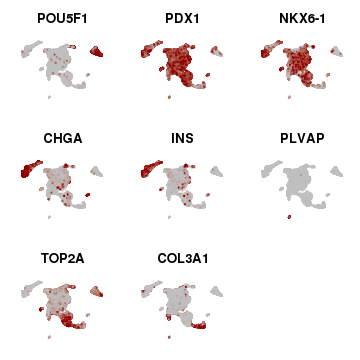

In [294]:
PlotGeneExpression(integrated)

# Figure 2E

In [234]:
pseudotime_meta = read.table(paste(out, "integrated_cluster0_pseudotime.txt", sep = ""))

In [257]:
integrated@meta.data$pseudotime      = as.numeric(pseudotime_meta[match(rownames(integrated@meta.data), rownames(pseudotime_meta)), "pseudotime"])
integrated@meta.data$pseudotime_bins = pseudotime_meta[match(rownames(integrated@meta.data), rownames(pseudotime_meta)), "quants"] 

In [296]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster0_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C0_test


In [318]:
load(paste(out, "obj.integrated.frazer.melton_cluster0_pseudotime", sep = ""))

In [316]:
colsUSE = cols[cols$celltype %in% (unique(integrated.C0_test@meta.data$Assigned_cluster)), "col" ][c(5, 6, 4, 3, 7, 1, 9, 8, 2)]
colsUSE = c( "#c7c7c7", colsUSE)

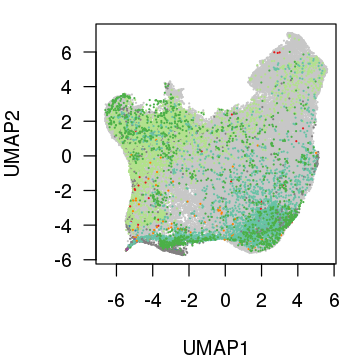

In [317]:
x = PlotUMAP(integrated.C0_test, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

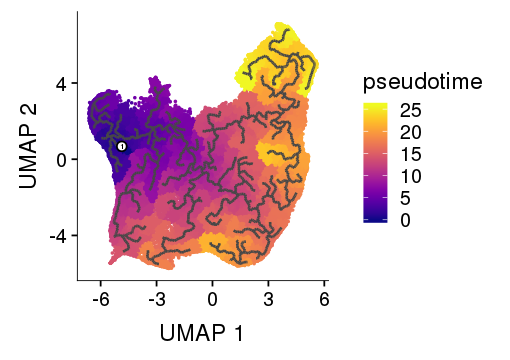

In [358]:
options(repr.plot.width = 4.25, repr.plot.height = 3)
plot_cells(cds, 
           color_cells_by = "pseudotime", 
           label_cell_groups=FALSE, 
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

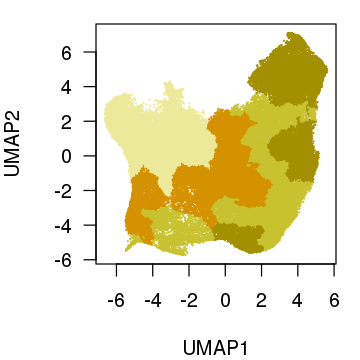

In [332]:
x = PlotUMAP(integrated.C0_test, "pseudotime_quantile", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = c("#d49100","#c9c230",
                                                                                                                     "#ede99a", "#a39000"))

In [338]:
# bin time by quantiles
pseudotime_ppc = as.data.frame(pseudotime(cds))
colnames(pseudotime_ppc) = "pseudotime"
quants = as.data.frame(quantile(pseudotime_ppc$pseudotime))

pseudotime_ppc$quants = NA
pseudotime_ppc$pseudotime = as.numeric(pseudotime_ppc$pseudotime)

pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[1, 1] & pseudotime_ppc$pseudotime <= quants[2, 1],  "quants" ] = "PPC_1"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[2, 1] & pseudotime_ppc$pseudotime <= quants[3, 1],  "quants" ] = "PPC_2"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[3, 1] & pseudotime_ppc$pseudotime <= quants[4, 1],  "quants" ] = "PPC_3"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[4, 1] & pseudotime_ppc$pseudotime <= quants[5, 1],  "quants" ] = "PPC_4"


pData(cds)$pseudotime_quantile = pseudotime_ppc[match(rownames(pData(cds)), rownames(pseudotime_ppc)), "quants"]

In [351]:
genes = c("PDX1", "NKX6-1")

genes2plot = cds[rowData(cds)$gene_short_name %in% genes,]

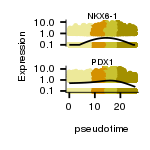

In [372]:
options(repr.plot.width = 1.25, repr.plot.height = 1.25)
plot_genes_in_pseudotime(genes2plot,color_cells_by="pseudotime_quantile", min_expr=0.1) +
    scale_color_manual(values = c("#ede99a", "#d49100","#c9c230", "#a39000"), guide = FALSE) +
    theme(text = element_text(size=6), axis.text.x = element_text(size=6), axis.text.y = element_text(size=6))

# Figure 2F

In [380]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster1_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C1


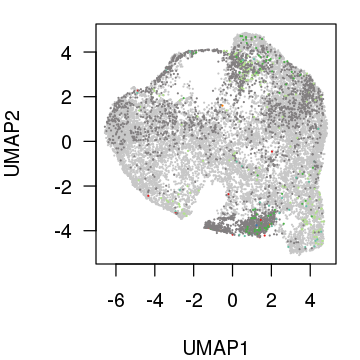

In [400]:
# cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "col" ][c(6, 5, 4, 7, 3, 2, 1, 8)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C1, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Figure 2G

In [379]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster2_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C2


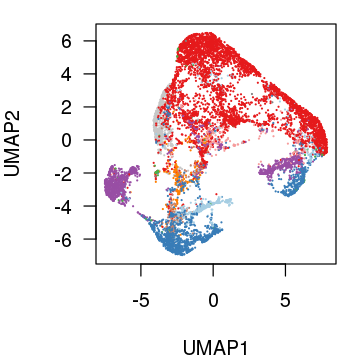

In [404]:
# cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "col" ][c(5, 7, 2, 4, 10, 6, 8, 9, 3, 1)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C2, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

# Figure 2H

In [287]:
colsUSE = cols[cols$celltype %in% (unique(integrated@meta.data$Assigned_cluster)), "col" ][c(7, 6, 5, 8, 2, 4, 11, 1, 9, 10, 3)]
colsUSE = c( "#c7c7c700", colsUSE)

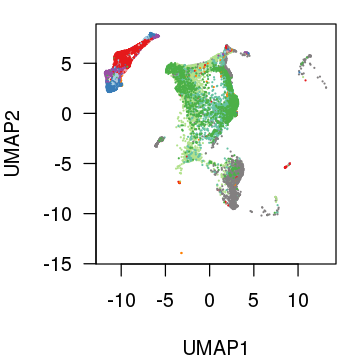

In [288]:
x = PlotUMAP(integrated, "Assigned_cluster", 2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)

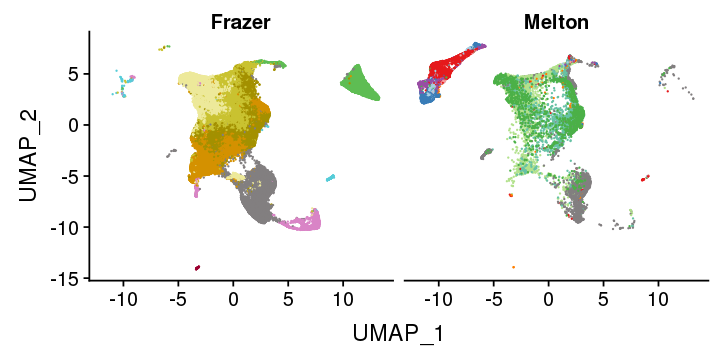

In [421]:
options(repr.plot.width = 6, repr.plot.height = 3)
DimPlot(integrated, group.by = "major_cell_population", split.by = "study", label = F, cols = cols$col) + NoLegend()

# Output

In [418]:
# out = "../Figures/Manuscript_V04/Figure_2_"

# png(paste(out, "UMAP_byCluster.png"), width = 3, height = 3, units = "in", res = 1200)
# x = PlotUMAP(integrated, "integrated_snn_res.0.05", 3, 13, text_width = 2, n.col = 2, plot_leg = F)
# dev.off()

# colsUSE = cols[cols$celltype %in% (unique(integrated@meta.data$Assigned_cluster)), "col" ][c(7, 6, 5, 8, 2, 4, 11, 1, 9, 10, 3)]
# colsUSE = c( "#c7c7c7", colsUSE)
# png(paste(out, "UMAP_byMeltonCelltype.png"), width = 3, height = 3, units = "in", res = 1200)
# x = PlotUMAP(integrated, "Assigned_cluster", 2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
# dev.off()

# pdf(paste(out, "Overall_Barplot.pdf"), width = 8, height = 6)
# PlotFractionCellsStudy()
# dev.off()

png(paste(out, "UMAP_expression.png"), width = 3, height = 3, units = "in", res = 1200)
PlotGeneExpression(integrated)
dev.off()

png 
  2

In [415]:
out = "../Figures/Manuscript_V04/Figure_2_"

png(paste(out, "UMAP_byCell_cluster0.png"), width = 3, height = 3, units = "in", res = 1200)
x = PlotUMAP(integrated.C0_test, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()

png(paste(out, "UMAP_byPseudotime_cluster0_lenged.png"), width = 10, height = 10, units = "in", res = 1200)
plot_cells(cds, color_cells_by = "pseudotime", label_cell_groups=FALSE, label_leaves=FALSE, label_branch_points=FALSE, graph_label_size=1.5)
dev.off()

png(paste(out, "UMAP_byPseudotimeBin_cluster0.png"), width = 3, height = 3, units = "in", res = 1200)
x = PlotUMAP(integrated.C0_test, "pseudotime_quantile", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = c("#d49100","#c9c230","#ede99a", "#a39000"))
dev.off()

png(paste(out, "Expression_over_pseudotime_legend.png"), width = 1.25, height = 1.25, units = "in", res = 1200)

plot_genes_in_pseudotime(genes2plot,color_cells_by="pseudotime_quantile", min_expr=0.1) +
    scale_color_manual(values = c("#ede99a", "#d49100","#c9c230", "#a39000"), guide = FALSE) +
    theme(text = element_text(size=6), axis.text.x = element_text(size=6), axis.text.y = element_text(size=6))
dev.off()

png 
  2

In [406]:
out = "../Figures/Manuscript_V04/Figure_2_"

png(paste(out, "UMAP_byCell_cluster1.png"), width = 3, height = 3, units = "in", res = 1200)
# cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C1@meta.data$Assigned_cluster)), "col" ][c(6, 5, 4, 7, 3, 2, 1, 8)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C1, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()

png(paste(out, "UMAP_byPseudotime_cluster2.png"), width = 3, height = 3, units = "in", res = 1200)
# cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "celltype"]
colsUSE = cols[cols$celltype %in% (unique(integrated.C2@meta.data$Assigned_cluster)), "col" ][c(5, 7, 2, 4, 10, 6, 8, 9, 3, 1)]
colsUSE = c( "#c7c7c7", colsUSE)
x = PlotUMAP(integrated.C2, "Assigned_cluster", -2, 0, text_width = 3, n.col = 2, plot_leg = F, cols2use = colsUSE)
dev.off()


png 
  2

png 
  2

In [422]:
out = "../Figures/Manuscript_V04/Figure_2_"
png(paste(out, "UMAP_bymajor_cell_population.png"), width = 6, height = 3, units = "in", res = 1200)
DimPlot(integrated, group.by = "major_cell_population", split.by = "study", label = F, cols = cols$col) + NoLegend()
dev.off()

png 
  2